In [1]:
import sys
import os
import random
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"
if os.path.exists('./core'):
    os.remove('./core')

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    sys.path.append('../symbolicregression/')

# Install

In [3]:
%%capture
if IN_COLAB:
    !pip install -q condacolab
    import condacolab
    condacolab.install()
    !git clone https://github.com/facebookresearch/symbolicregression symbolic
    %mv ./symbolic/* ./
    %rm -rf symbolic
    !conda env create --name symbolic regression --file=environment.yml
    !conda init
    !activate symbolic
    !pip install git+https://github.com/pakamienny/sympytorch
    !conda install -c conda-forge pysr
    !conda install -c conda-forge julia
    !python3 -m pysr install

In [4]:
import pysr
from pysr import PySRRegressor
pysr.julia_helpers.init_julia()

<module 'julia.Main' (<julia.core.JuliaModuleLoader object at 0x7fa0507e1a90>)>

In [5]:
from utils import *
set_seed(274)

/ksozykinraid/miniconda/envs/symbolic3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
## Tranfsormer Model

In [7]:
transformer=get_transformer_model()

cuda:0
Model successfully loaded!


# Known Potential experiment

In [8]:
th = 0.5

In [9]:
arr = pd.read_csv('./data/points_elipse2.csv',header=None).values
indeces = np.where(arr[:,0] < th)[0]
indeces = np.random.choice(indeces, round(len(indeces)*0.005))
indeces2 = np.where(arr[:,0] >= th)[0]
arr = np.concatenate ((arr[indeces], arr[indeces2]))
df = pd.DataFrame(arr)
df.columns='j2,x,y,t'.split(',')
df = df.sort_values('j2')[::5]

In [10]:

df = df.reset_index().drop('index',1)
n_train = int(len(df)*0.9)
train_index = np.random.choice(df.index,n_train)
test_index = np.array([i for i in df.index if i not in train_index])
robot_df_train = df.iloc[train_index]
robot_df_test = df.iloc[test_index]


/ksozykinraid/miniconda/envs/symbolic3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [11]:
df

,j2,x,y,t
0,0.031250,0.050505,5.000000,3.14
1,0.034768,4.797980,4.898990,6.28
2,0.040787,4.595960,0.252525,6.28
3,0.044788,0.959596,0.000000,3.14
4,0.047325,0.555556,0.404040,4.71
...,...,...,...,...
1263,45.589996,2.575758,2.525253,0.00
1264,45.621245,2.525253,2.474747,4.71
1265,45.621245,2.474747,2.474747,4.71
1266,45.621245,2.525253,2.525253,6.28


In [12]:
P = robot_df_train['x,y,t'.split(',')].values
j2 = robot_df_train['j2'].values

In [13]:
t = perf_counter()
transformer.fit(P,j2)
t = perf_counter() - t

In [14]:
replace_ops = {"add": "+", "mul": "*", "sub": "-", "pow": "**", "inv": "1/",'x_0':'x','x_1':'y','x_2':'t'}
transformer_str = transformer.retrieve_tree(with_infos=True)["relabed_predicted_tree"].infix()
for op,replace_op in replace_ops.items():
    transformer_str = transformer_str.replace(op,replace_op)

In [15]:
robot_model_transformer = round_expr(sp.parse_expr(transformer_str),5)

In [16]:
j2_approx_tranfromer=sp.lambdify(['x','y','t'],robot_model_transformer,"numpy")

In [17]:
robot_df_train.iloc[:,1:].values

array([[2.42424242, 2.92929293, 0.        ],
       [1.71717172, 2.57575758, 6.28      ],
       [1.81818182, 3.13131313, 3.14      ],
       ...,
       [2.52525253, 1.66666667, 0.        ],
       [1.66666667, 2.52525253, 4.71      ],
       [2.92929293, 2.92929293, 4.71      ]])

In [18]:
try:
    approx_train = j2_approx_tranfromer(robot_df_train['x'].values,
                                        robot_df_train['y'].values,
                                        robot_df_train['t'].values)
    train_err = mse(approx_train,robot_df_train['j2'])
    approx_test = j2_approx_tranfromer(robot_df_test['x'].values,
                                       robot_df_test['y'].values,
                                       robot_df_test['t'].values)
    test_err = mse(approx_test,robot_df_test['j2'])
    print(train_err,test_err)
except Exception as e:
    print(e)

59.4898946357586 66.8062564857626


In [25]:
arr[:,3]

array([0.  , 6.28, 3.14, ..., 0.  , 4.71, 4.71])

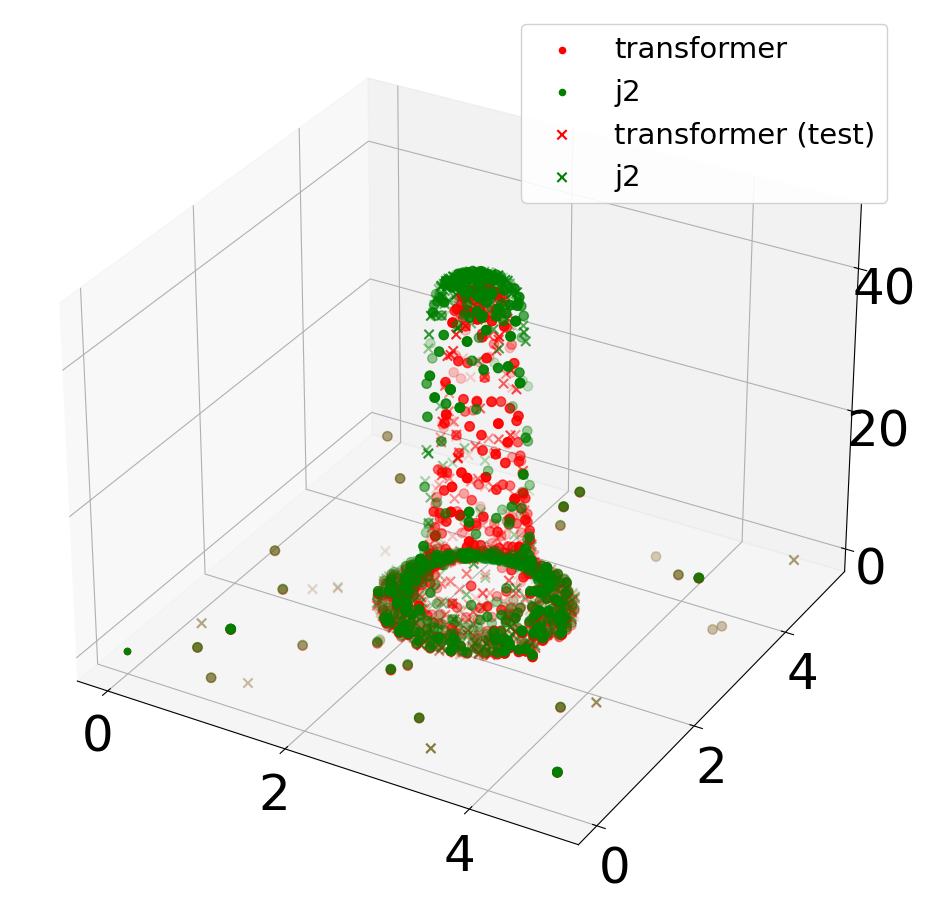

In [35]:
from matplotlib.colors import to_rgb, to_rgba

fig = plt.figure(figsize=(10,10))
s = 45
arr = robot_df_train.values
ax = fig.add_subplot(111, projection='3d')
ax.scatter(0,0,0,color='red',label='transformer')
ax.scatter(0,0,0,color='green',label='j2')

r,g,b = to_rgb('red')
alpha = arr[:,3]/(2*pi)
color = [(r, g, b, a) for a in alpha]
ax.scatter(arr[:,1], arr[:,2], 
           j2_approx_tranfromer(arr[:,1],arr[:,2],arr[:,3]),color=color,s=s)
r,g,b = to_rgb('green')
alpha = arr[:,3]/(2*pi)
color = [(r, g, b, a) for a in alpha]
ax.scatter(arr[:,1], arr[:,2], 
           arr[:,0],color=color,s=s)


arr = robot_df_test.values
r,g,b = to_rgb('red')
alpha = arr[:,3]/(2*pi)
color = [(r, g, b, a) for a in alpha]
ax.scatter(arr[:,1], arr[:,2], 
           j2_approx_tranfromer(arr[:,1],arr[:,2],arr[:,3]),color=color,label='transformer (test)',marker='x',s=s)
r,g,b = to_rgb('green')
alpha = arr[:,3]/(2*pi)
color = [(r, g, b, a) for a in alpha]
ax.scatter(arr[:,1], arr[:,2], 
           arr[:,0],color=color,label='j2',marker='x',s=s)

plt.legend()
plt.tight_layout()
plt.show()

In [20]:
print(robot_model_transformer)

0.00859 + 78.2/(1.79 - 0.00454*(0.01549*t + (3.53392 - 1.40275*y)*(0.0042*t + 25.15625*y - 63.2532) + (7.61116 - 3.05213*x)*(17.06737*x - 43.60823) - 0.04)**3)


In [21]:
assert

SyntaxError: invalid syntax (2389114725.py, line 1)

In [ ]:
nproc = 64

In [ ]:

robot_model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    procs = nproc,
    binary_operators=["+",'-', "*",],
    temp_equation_file=True,
    delete_tempfiles=True,
    unary_operators=[
        "atan",
        "exp",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

In [ ]:
t2 = perf_counter()
robot_model.fit(P[:],j2[:])
t2 = perf_counter()-t2

In [ ]:
print(t2)

In [ ]:
if os.path.exists('./core'):
    os.remove('./core')

In [ ]:
save_eq = False

In [ ]:
best_eq_id = robot_model.equations_['loss'].argmin()

In [ ]:
if save_eq:
    robot_model.equations_.to_csv('./'+'robot_model.equations_.csv'.replace('.','_'))

In [ ]:
robot_model_pysr = robot_model.equations_.iloc[best_eq_id]['equation']
robot_model_pysr = str(round_expr(sp.parse_expr(robot_model_pysr),5))
robot_model_pysr = robot_model_pysr.replace('x0','x').replace('x1','y').replace('atan','arctan').replace('x2','t')

In [ ]:
str(robot_model_pysr)

In [ ]:
j2_approx_pysr=sp.lambdify(['x','y','t'],robot_model_pysr, modules=["numpy"])

In [ ]:
try:
    approx_train = j2_approx_pysr(robot_df_train['x'].values,
                                        robot_df_train['y'].values,
                                        robot_df_train['t'].values)
    train_err = mse(approx_train,robot_df_train['j2'])
    approx_test = j2_approx_pysr(robot_df_test['x'].values,
                                       robot_df_test['y'].values,
                                       robot_df_test['t'].values)
    test_err = mse(approx_test,robot_df_test['j2'])
    print(train_err,test_err)
except Exception as e:
    print(e)

In [ ]:
np.arctan

In [ ]:
params = {'text.usetex' : False,
          'font.size' : 36,
          'legend.fancybox':True,
          'legend.loc' : 'best',

          'legend.framealpha': 0.9,
          "legend.fontsize" : 21,
         }
plt.rcParams.update(params)

In [ ]:
fig = plt.figure(figsize=(15,15))
arr = robot_df_train.values
s=90
ax = fig.add_subplot(111, projection='3d')
plt.xlabel("x")
plt.ylabel("y")
ax.scatter(arr[:,1], arr[:,2], 
           j2_approx_pysr(arr[:,1],arr[:,2],arr[:,3]),color='red',label='transformer',s=s)
ax.scatter(arr[:,1], arr[:,2], 
           j2_approx_pysr(arr[:,1],arr[:,2],arr[:,3]),color='magenta',label='pysr',s=s)
ax.scatter(arr[:,1], arr[:,2], 
           arr[:,0],color='green',label='j2',s=s)

arr = robot_df_test.values

ax.scatter(arr[:,1], arr[:,2], 
           j2_approx_pysr(arr[:,1],arr[:,2],arr[:,3]),color='red',marker='x',s=s)
ax.scatter(arr[:,1], arr[:,2], 
           j2_approx_pysr(arr[:,1],arr[:,2],arr[:,3]),color='magenta',marker='x',s=s)
ax.scatter(arr[:,1], arr[:,2], 
           arr[:,0],color='green',marker='x',s=s)
ax.scatter(0,0,color='black',marker='o',label='train',s=90)
ax.scatter(0,0,color='black',marker='x',label='test',s=90)

plt.legend()
plt.tight_layout()

## equations

In [ ]:
print(robot_model_transformer)

In [ ]:
print(robot_model_pysr)